In [1]:
import PIL, torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from torchvision import models
from torch import nn

from load_data import load_et_maps, load_images, load_labels, classes
from load_models import load_mobilenet, load_resnet
from utils import batch_accuracy


if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)
dtype = torch.float32

OCC_ONLY = Path('/home/florian/MT-Roxi/Occ_only_226px/')
IMGS = Path('/home/florian/MT-Roxi/scaled images/')
OCC = Path('/home/florian/MT-Roxi/tobii_export/')

cuda:0


# Extract Labels

In [2]:
img_batch = load_images(IMGS).to(device)
etm_batch = load_et_maps(OCC_ONLY).to(device)
labels = load_labels(IMGS).to(device)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
MOBILENET_PATH = './models/MobileNetV3Small.pt'
model = load_mobilenet(MOBILENET_PATH).to(device)
batch_accuracy(model, img_batch, labels)

## Attacks

In [14]:
def FGSM(model, inputs, eps=8/255, use_eye_tracking_maps = True):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    inputs.to(device)
    inputs.requires_grad = True
    preds = model(inputs)
    loss = criterion(preds, labels.long())
    loss.backward(retain_graph=True)
    grads = inputs.grad
    
    if use_eye_tracking_maps==False:
        perturbation = torch.sign(grads).clamp_(-eps,eps)
        adv_examples = img_batch + perturbation
        adv_examples.clamp_(0,1).detach_()

    if use_eye_tracking_maps==True:
        perturbation = torch.sign(grads).clamp_(-eps,eps)
        perturbation = .5*perturbation + .5*perturbation*(1-etm_batch)
        adv_examples = img_batch + perturbation
        adv_examples.clamp_(0,1).detach_()
    return adv_examples, perturbation
model = mobilenet

#Tests
accs = []
for i, eps in enumerate([.0,.01,.02,.03]):
    adv_examples, perturbation = FGSM(model, img_batch, eps=eps, use_eye_tracking_maps=False)
    assert perturbation.abs().max() <= eps
    assert adv_examples.min() >= 0
    assert adv_examples.max() <= 1
    accs.append(batch_accuracy(adv_examples, labels))
    if i>0:
        assert accs[-1]<=accs[-2] #
    
for eps in [.1,.2,.3]:
    hpa_adv_examples, hpa_perturbation = FGSM(model, img_batch, eps=eps, use_eye_tracking_maps=True)
    assert hpa_perturbation.abs().max() <= eps
    assert hpa_adv_examples.min() >= 0
    assert hpa_adv_examples.max() <= 1

In [15]:
def FGSM_step(model, inputs, criterion, eps):
    preds = model(inputs)
    loss = criterion(preds, labels.long())
    loss.backward(retain_graph=True)
    grads = inputs.grad
    perturbation = torch.sign(grads).clamp_(-eps,eps)
    return perturbation

def PGD(model, inputs, steps, eps, stepsize=None, use_eye_tracking_maps = True, random_start=False):
    if stepsize == None: stepsize = eps/steps * 5
    model.eval()
    criterion = nn.CrossEntropyLoss()
    if random_start == False: perturbation = torch.zeros_like(inputs)
    if random_start == True: perturbation = torch.randn_like(inputs) * (1-etm_batch)
    adv_examples = inputs+perturbation
    inputs.requires_grad = True
    adv_examples.retain_grad()
    for step in range(steps):
        pert_step = FGSM_step(model, adv_examples, criterion, stepsize)
        perturbation += pert_step
        if use_eye_tracking_maps == True: 
            perturbation = perturbation.clamp(-eps,eps)
            perturbation = 0.5*perturbation + 0.5* perturbation * (1-etm_batch)
            assert (perturbation<(1-.5*etm_batch)).all()
            #perturbation = perturbation.clamp(min=-(etm_batch*0.5*eps+0.5*eps), max=(etm_batch*0.5*eps)+0.5*eps)
        else: perturbation = perturbation.clamp(-eps,eps)
        adv_examples = inputs + perturbation
        adv_examples.retain_grad()
    perturbation = perturbation.clamp(-eps,eps)
    perturbation.abs().max()
    adv_examples = (inputs+perturbation).clamp(0,1)
    return perturbation, adv_examples

perturbation, adv_examples = PGD(model, img_batch, 5, 8/255, use_eye_tracking_maps=False, random_start=True)
perturbation, adv_examples = PGD(model, img_batch, 5, 8/255, use_eye_tracking_maps=True, random_start=True)



# Tests

In [16]:
STEPS = 10
ifgsm_acc_5 = []
ifgsm_hpa_acc_5 = []
pgd_acc_5 = []
pgd_hpa_acc_5 = []
epsilons = (torch.Tensor([0,1,2,4,8,16]))/255
for i, eps in enumerate(epsilons):
    ifgsm_perturbation, ifgsm_adv_examples = PGD(model, img_batch,STEPS, eps=eps, random_start=False, use_eye_tracking_maps=False)
    ifgsm_hpa_perturbation, ifgsm_hpa_adv_examples = PGD(model, img_batch,STEPS, eps=eps, random_start=False, use_eye_tracking_maps=True)
    pgd_perturbation, pgd_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=False)
    pgd_hpa_perturbation, pgd_hpa_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=True)
    ifgsm_acc_5.append(batch_accuracy(ifgsm_adv_examples, labels))
    ifgsm_hpa_acc_5.append(batch_accuracy(ifgsm_hpa_adv_examples, labels))
    pgd_acc_5.append(batch_accuracy(pgd_adv_examples, labels))
    pgd_hpa_acc_5.append(batch_accuracy(pgd_hpa_adv_examples, labels))
    clean_acc = batch_accuracy(img_batch, labels)
    print('Epsilon:', str(int(eps.item()*255))+'/255',
          ' - IFGSM accuracy:', ifgsm_acc_5[-1],
          ' - HPA-IFGSM accuracy:', ifgsm_hpa_acc_5[-1],
          ' - PGD accuracy:', pgd_acc_5[-1],
          ' - HPA-PGD accuracy:', pgd_hpa_acc_5[-1],
          ' - clean accuracy:', clean_acc,
    )
    assert ifgsm_acc_5[-1]<=ifgsm_hpa_acc_5[-1] #test that hpa restricted attack is less effective
    assert pgd_acc_5[-1]<=pgd_hpa_acc_5[-1] #test that hpa restricted attack is less effective
    
    if i>0:
        print(ifgsm_hpa_acc_5[-1], ifgsm_hpa_acc_5[-2])
        assert ifgsm_acc_5[-1]<=ifgsm_acc_5[-2] #
        assert ifgsm_hpa_acc_5[-1]<=ifgsm_hpa_acc_5[-2]
        assert pgd_acc_5[-1]<=pgd_hpa_acc_5[-2]
        assert pgd_hpa_acc_5[-1]<=pgd_hpa_acc_5[-2]

STEPS = 30
ifgsm_acc_50 = []
ifgsm_hpa_acc_50 = []
pgd_acc_50 = []
pgd_hpa_acc_50 = []
epsilons = (torch.Tensor([0,1,2,4,8,16]))/255
for i, eps in enumerate(epsilons):
    ifgsm_perturbation, ifgsm_adv_examples = PGD(model, img_batch, STEPS, eps=eps, random_start=False, use_eye_tracking_maps=False)
    ifgsm_hpa_perturbation, ifgsm_hpa_adv_examples = PGD(model, img_batch,STEPS, eps=eps, random_start=False, use_eye_tracking_maps=True)
    pgd_perturbation, pgd_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=False)
    pgd_hpa_perturbation, pgd_hpa_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=True)
    ifgsm_acc_50.append(batch_accuracy(ifgsm_adv_examples, labels))
    ifgsm_hpa_acc_50.append(batch_accuracy(ifgsm_hpa_adv_examples, labels))
    pgd_acc_50.append(batch_accuracy(pgd_adv_examples, labels))
    pgd_hpa_acc_50.append(batch_accuracy(pgd_hpa_adv_examples, labels))
    clean_acc = batch_accuracy(img_batch, labels)
    print('Epsilon:', str(int(eps.item()*255))+'/255',
          ' - IFGSM accuracy:', ifgsm_acc_50[-1],
          ' - HPA-IFGSM accuracy:', ifgsm_hpa_acc_50[-1],
          ' - PGD accuracy:', pgd_acc_50[-1],
          ' - HPA-PGD accuracy:', pgd_hpa_acc_50[-1],
          ' - clean accuracy:', clean_acc,
    )
    assert ifgsm_acc_50[-1]<=ifgsm_hpa_acc_50[-1] #test that hpa restricted attack is less effective
    assert pgd_acc_50[-1]<=pgd_hpa_acc_50[-1] #test that hpa restricted attack is less effective
    if i>0:
        assert ifgsm_acc_50[-1]<=ifgsm_acc_50[-2] #test that higher eps increases attack effectivness
        assert ifgsm_hpa_acc_50[-1]<=ifgsm_hpa_acc_50[-2] #test that higher eps increases attack effectivness
        assert pgd_acc_50[-1]<=pgd_hpa_acc_50[-2] #test that higher eps increases attack effectivness
        assert pgd_hpa_acc_50[-1]<=pgd_hpa_acc_50[-2] #test that higher eps increases attack effectivness

for i in range(len(ifgsm_acc_50)): # Test that the 50 step attack is more effective than the 5 step attack
    print(i)
    print(ifgsm_hpa_acc_50[i],ifgsm_hpa_acc_5[i])
    assert ifgsm_acc_50[i]<=ifgsm_acc_5[i]
    assert ifgsm_hpa_acc_50[i]<=ifgsm_hpa_acc_5[i]
    assert pgd_acc_50[i]<=pgd_acc_5[i]
    assert pgd_hpa_acc_50[i]<=pgd_hpa_acc_5[i]

Epsilon: 0/255  - IFGSM accuracy: 1.0  - HPA-IFGSM accuracy: 1.0  - PGD accuracy: 1.0  - HPA-PGD accuracy: 1.0  - clean accuracy: 1.0
Epsilon: 1/255  - IFGSM accuracy: 0.04  - HPA-IFGSM accuracy: 0.08  - PGD accuracy: 0.05  - HPA-PGD accuracy: 0.08  - clean accuracy: 1.0
0.08 1.0
Epsilon: 2/255  - IFGSM accuracy: 0.0  - HPA-IFGSM accuracy: 0.01  - PGD accuracy: 0.01  - HPA-PGD accuracy: 0.01  - clean accuracy: 1.0
0.01 0.08
Epsilon: 4/255  - IFGSM accuracy: 0.0  - HPA-IFGSM accuracy: 0.0  - PGD accuracy: 0.0  - HPA-PGD accuracy: 0.0  - clean accuracy: 1.0
0.0 0.01
Epsilon: 8/255  - IFGSM accuracy: 0.0  - HPA-IFGSM accuracy: 0.0  - PGD accuracy: 0.0  - HPA-PGD accuracy: 0.0  - clean accuracy: 1.0
0.0 0.0
Epsilon: 16/255  - IFGSM accuracy: 0.0  - HPA-IFGSM accuracy: 0.0  - PGD accuracy: 0.0  - HPA-PGD accuracy: 0.0  - clean accuracy: 1.0
0.0 0.0
Epsilon: 0/255  - IFGSM accuracy: 1.0  - HPA-IFGSM accuracy: 1.0  - PGD accuracy: 1.0  - HPA-PGD accuracy: 1.0  - clean accuracy: 1.0
Epsilon: 1

# Visualize

In [17]:
eps = 4/255
STEPS = 10
ifgsm_perturbation, ifgsm_adv_examples = PGD(model, img_batch, STEPS, eps=eps, random_start=False, use_eye_tracking_maps=False)
ifgsm_hpa_perturbation, ifgsm_hpa_adv_examples = PGD(model, img_batch,STEPS, eps=eps, random_start=False, use_eye_tracking_maps=True)
pgd_perturbation, pgd_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=False)
pgd_hpa_perturbation, pgd_hpa_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=True)

print(
    batch_accuracy(ifgsm_adv_examples, labels),
    batch_accuracy(ifgsm_hpa_adv_examples, labels),
    batch_accuracy(pgd_adv_examples, labels),
    batch_accuracy(pgd_hpa_adv_examples, labels)
)

0.0 0.0 0.0 0.0


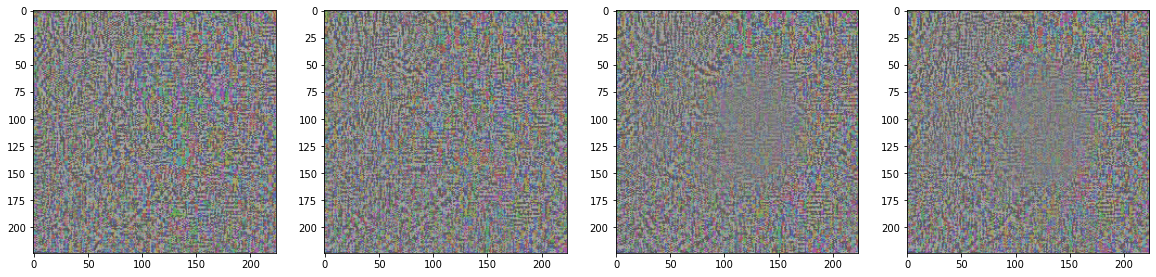

In [18]:
fig, axes = plt.subplots(1,4, figsize=(20,10))
axes = axes.flatten()
axes[0].imshow(ifgsm_perturbation[0].detach().cpu().permute(1,2,0)*10+.5)
axes[1].imshow(pgd_perturbation[0].detach().cpu().permute(1,2,0)*10+.5)
axes[2].imshow(ifgsm_hpa_perturbation[0].detach().cpu().permute(1,2,0)*10+.5)
axes[3].imshow(pgd_hpa_perturbation[0].detach().cpu().permute(1,2,0)*10+.5)

In [19]:
print(
    ifgsm_perturbation[0].abs().mean(),
    ifgsm_perturbation[0].abs().max(),
    ifgsm_perturbation[0].abs().min()
)

print(
    pgd_perturbation[0].abs().mean(),
    pgd_perturbation[0].abs().max(),
    pgd_perturbation[0].abs().min()
)

print(
    ifgsm_hpa_perturbation[0].abs().mean(),
    ifgsm_hpa_perturbation[0].abs().max(),
    ifgsm_hpa_perturbation[0].abs().min()
)

print(
    pgd_hpa_perturbation[0].abs().mean(),
    pgd_hpa_perturbation[0].abs().max(),
    pgd_hpa_perturbation[0].abs().min()
)

tensor(0.0107, device='cuda:0') tensor(0.0157, device='cuda:0') tensor(0., device='cuda:0')
tensor(0.0107, device='cuda:0') tensor(0.0157, device='cuda:0') tensor(0., device='cuda:0')
tensor(0.0093, device='cuda:0') tensor(0.0157, device='cuda:0') tensor(0., device='cuda:0')
tensor(0.0094, device='cuda:0') tensor(0.0157, device='cuda:0') tensor(0., device='cuda:0')


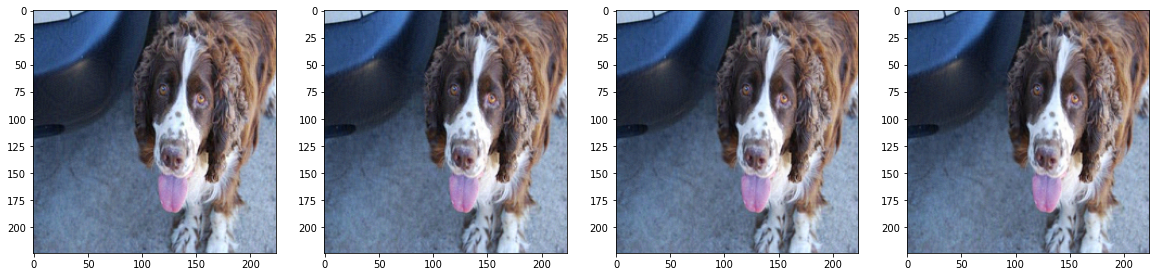

In [20]:
fig, axes = plt.subplots(1,4, figsize=(20,10))
axes = axes.flatten()
axes[0].imshow(ifgsm_adv_examples[0].detach().cpu().permute(1,2,0))
axes[1].imshow(pgd_adv_examples[0].detach().cpu().permute(1,2,0))
axes[2].imshow(ifgsm_hpa_adv_examples[0].detach().cpu().permute(1,2,0))
axes[3].imshow(pgd_hpa_adv_examples[0].detach().cpu().permute(1,2,0))

In [21]:
def viz(inp):
    plt.imshow((inp).detach().cpu().permute(1,2,0))
def viz_etm(inp):
    plt.imshow(inp.detach().cpu().permute(1,2,0))
def viz_pert(inp):
    plt.imshow((inp+0.5).detach().cpu().permute(1,2,0))

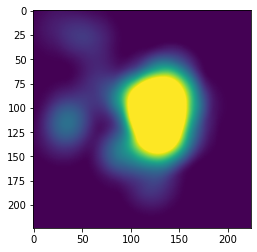

In [22]:
viz_etm(etm_batch[0])

tensor(-0.0314, device='cuda:0')


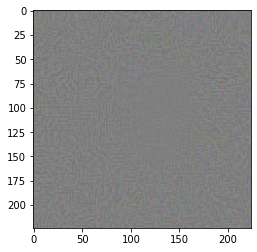

In [23]:
print(perturbation.min())
viz_pert(perturbation[0])

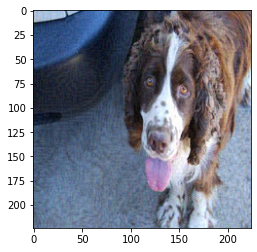

In [24]:
viz(adv_examples[0])

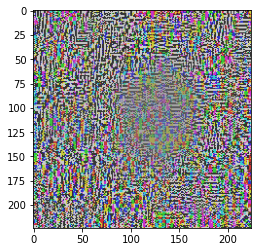

In [25]:
viz_pert(hpa_perturbation[0])

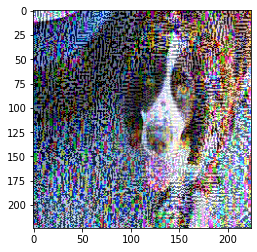

In [26]:
viz(hpa_adv_examples[0])

In [46]:
import foolbox
from foolbox.attacks import PGD, FGSM

In [47]:
attack = FGSM()

In [48]:
img_batch.requires_grad_(False)
model.eval()
fmodel = foolbox.PyTorchModel(
    model.to(device), 
    bounds=(0,1), 
    #preprocessing=dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
)
raw_advs, clipped_advs, success = attack(
    fmodel, 
    img_batch.to(device), 
    criterion=labels.long().to(device), 
    epsilons=[8/255]
)

In [49]:
clipped_advs

[tensor([[[[0.6863, 0.6941, 0.6353,  ..., 0.4745, 0.5255, 0.5294],
           [0.6235, 0.6314, 0.6353,  ..., 0.4706, 0.5451, 0.5373],
           [0.6235, 0.6314, 0.6353,  ..., 0.4980, 0.5216, 0.5216],
           ...,
           [0.3451, 0.3843, 0.4157,  ..., 0.5098, 0.5294, 0.5176],
           [0.3529, 0.3882, 0.4314,  ..., 0.5451, 0.5098, 0.5020],
           [0.3686, 0.3882, 0.4196,  ..., 0.4980, 0.5373, 0.5059]],
 
          [[0.7647, 0.7725, 0.7137,  ..., 0.3765, 0.4235, 0.3647],
           [0.7020, 0.7098, 0.7137,  ..., 0.3804, 0.4471, 0.4353],
           [0.7020, 0.7098, 0.7137,  ..., 0.3490, 0.4314, 0.4235],
           ...,
           [0.4196, 0.4627, 0.4941,  ..., 0.5765, 0.6588, 0.6471],
           [0.4431, 0.4784, 0.5255,  ..., 0.6118, 0.6392, 0.6314],
           [0.4706, 0.4902, 0.5216,  ..., 0.5647, 0.6039, 0.5725]],
 
          [[0.8706, 0.8784, 0.8196,  ..., 0.3922, 0.3765, 0.3765],
           [0.8078, 0.8157, 0.8196,  ..., 0.4000, 0.4039, 0.3882],
           [0.8078, 0.81